# Histogram of voxel spacing 

Analyzing files in: C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_images

--- Analysis Complete ---
Processed 447 images.


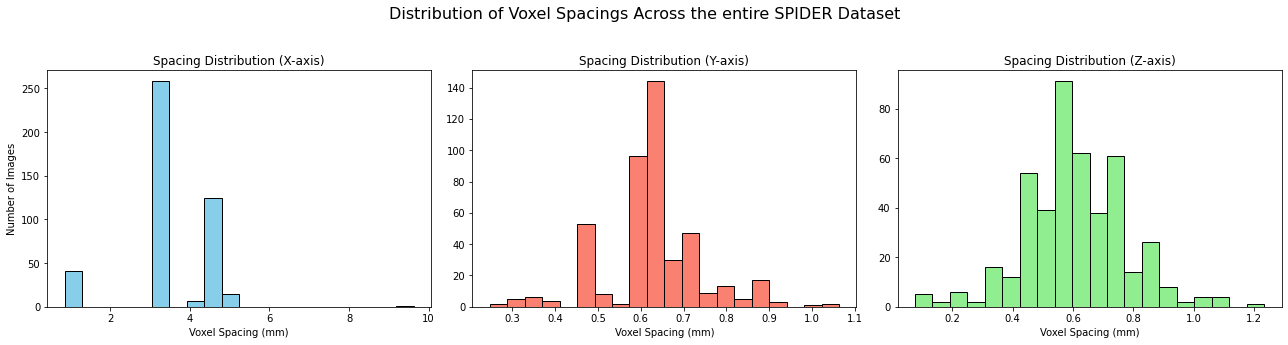

In [13]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def plot_voxel_spacing(data_folder):
    spacings_x = []
    spacings_y = []
    spacings_z = []

    print(f"Analyzing files in: {data_folder}")

    # Loop for all files
    for filename in os.listdir(data_folder):
        if filename.endswith((".nii", ".nii.gz")):
            image_path = os.path.join(data_folder, filename)
            try:
                # Load image and its header
                img = nib.load(image_path)
                header = img.header
                
                # Get voxel spacing (zooms)
                zooms = header.get_zooms()
                
                # The zooms tuple contains spacing for (X, Y, Z) axes
                spacings_x.append(zooms[0])
                spacings_y.append(zooms[1])
                spacings_z.append(zooms[2])

            except Exception as e:
                print(f"Could not process {filename}: {e}")

    if not spacings_x:
        print("No valid NIfTI files found or processed.")
        return

    print("\n--- Analysis Complete ---")
    print(f"Processed {len(spacings_x)} images.")
    
    # --- Histograms ---
    
    # Plot figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Distribution of Voxel Spacings Across the entire SPIDER Dataset', fontsize=16)

    # Histogram for X-axis spacing
    axs[0].hist(spacings_x, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title('Spacing Distribution (X-axis)')
    axs[0].set_xlabel('Voxel Spacing (mm)')
    axs[0].set_ylabel('Number of Images')

    # Histogram for Y-axis spacing
    axs[1].hist(spacings_y, bins=20, color='salmon', edgecolor='black')
    axs[1].set_title('Spacing Distribution (Y-axis)')
    axs[1].set_xlabel('Voxel Spacing (mm)')
  

    # Histogram for Z-axis spacing
    axs[2].hist(spacings_z, bins=20, color='lightgreen', edgecolor='black')
    axs[2].set_title('Spacing Distribution (Z-axis)')
    axs[2].set_xlabel('Voxel Spacing (mm)')


    # Improve layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


cleaned_folder = 'C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_images'
plot_voxel_spacing(cleaned_folder)

In [14]:
import os
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def create_stratified_split(data_folder, test_size=0.2, random_state=42):
    """
    Creates a stratified train/test split based on the X-axis voxel spacing.

    Args:
        data_folder (str): Path to the folder with cleaned NIfTI files.
        test_size (float): The proportion of the dataset to allocate to the test set.
        random_state (int): Seed for the random number generator for reproducibility.
    """
    
    filepaths = []
    spacings = []

    print(f"Analyzing files in: {data_folder} to determine strata...")

    # First, get the spacing for every file
    for filename in os.listdir(data_folder):
        if filename.endswith((".nii", ".nii.gz")):
            image_path = os.path.join(data_folder, filename)
            try:
                img = nib.load(image_path)
                # We stratify on the X-axis spacing (slice thickness)
                spacing_x = img.header.get_zooms()[0]
                
                filepaths.append(filename)
                spacings.append(spacing_x)
            except Exception as e:
                print(f"Could not process {filename}: {e}")

    if not filepaths:
        print("No valid NIfTI files found.")
        return

    # Define bins for stratification based on the histogram you saw.
    # Spacings are continuous, so we create discrete bins.
    # Bin 1: < 3.5 (the ~3.3mm group)
    # Bin 2: 3.5 to 4.5 (the ~4.0mm group)
    # Bin 3: > 4.5 (the ~5.0mm group)
    bins = np.digitize(spacings, bins=[3.5, 4.5])
    
    # Use scikit-learn's train_test_split with the 'stratify' option
    train_files, test_files, _, _ = train_test_split(
        filepaths, 
        spacings, # This second list is just for length, it's not used in the output
        test_size=test_size, 
        random_state=random_state,
        stratify=bins # This is the key argument!
    )

    print("\n--- Split Complete ---")
    print(f"Total images: {len(filepaths)}")
    print(f"Training set size: {len(train_files)} images")
    print(f"Testing set size: {len(test_files)} images")

    # (Optional) Verify the distribution in each set
    print("\nVerifying stratification...")
    verify_split_distribution(data_folder, train_files, "Training Set")
    verify_split_distribution(data_folder, test_files, "Testing Set")
    
    return train_files, test_files

def verify_split_distribution(data_folder, file_list, set_name):
    """Helper function to print the distribution of spacings in a file list."""
    distribution = defaultdict(int)
    for filename in file_list:
        img_path = os.path.join(data_folder, filename)
        spacing_x = nib.load(img_path).header.get_zooms()[0]
        # Categorize into the same bins
        if spacing_x < 3.5:
            distribution['~3.3mm group'] += 1
        elif spacing_x < 4.5:
            distribution['~4.0mm group'] += 1
        else:
            distribution['~5.0mm group'] += 1
    
    print(f"\n--- {set_name} Distribution ---")
    total = sum(distribution.values())
    for group, count in distribution.items():
        percentage = (count / total) * 100 if total > 0 else 0
        print(f"  {group}: {count} images ({percentage:.1f}%)")


# --- Usage ---
cleaned_folder = 'C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_images'
train_filenames, test_filenames = create_stratified_split(cleaned_folder)

# The lists 'train_filenames' and 'test_filenames' now hold the names of the
# files for your two sets.
# print("\nSample of training files:", train_filenames[:5])
# print("\nSample of testing files:", test_filenames[:5])

Analyzing files in: C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_images to determine strata...

--- Split Complete ---
Total images: 447
Training set size: 357 images
Testing set size: 90 images

Verifying stratification...

--- Training Set Distribution ---
  ~5.0mm group: 56 images (15.7%)
  ~4.0mm group: 62 images (17.4%)
  ~3.3mm group: 239 images (66.9%)

--- Testing Set Distribution ---
  ~4.0mm group: 16 images (17.8%)
  ~3.3mm group: 60 images (66.7%)
  ~5.0mm group: 14 images (15.6%)


In [15]:
import os
import shutil
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

def verify_split_distribution(data_folder, file_list, set_name):
    """Helper function to print the distribution of spacings in a file list."""
    distribution = defaultdict(int)
    for filename in file_list:
        img_path = os.path.join(data_folder, filename)
        try:
            spacing_x = nib.load(img_path).header.get_zooms()[0]
            # Categorize into the same bins
            if spacing_x < 3.5:
                distribution['~3.3mm group'] += 1
            elif spacing_x < 4.5:
                distribution['~4.0mm group'] += 1
            else:
                distribution['~5.0mm group'] += 1
        except Exception as e:
            print(f"Warning: Could not read {filename} for verification. Error: {e}")
    
    print(f"\n--- {set_name} Distribution ---")
    total = sum(distribution.values())
    # Sort by group name for consistent order
    for group in sorted(distribution.keys()):
        count = distribution[group]
        percentage = (count / total) * 100 if total > 0 else 0
        print(f"  {group}: {count} images ({percentage:.1f}%)")

def create_physical_split_with_verification(
    source_images_folder, 
    source_labels_folder, 
    output_base_folder,
    test_size=0.2, 
    random_state=42
):
    """
    Performs a stratified split, prints a detailed verification report, and
    physically copies images and labels into train and test directories.
    """
    
    # --- 1. Perform the Stratified Split ---
    
    filepaths = []
    spacings = []

    print(f"Analyzing files in: {source_images_folder} to determine strata...")

    for filename in os.listdir(source_images_folder):
        if filename.endswith((".nii", ".nii.gz")):
            image_path = os.path.join(source_images_folder, filename)
            try:
                img = nib.load(image_path)
                spacings.append(img.header.get_zooms()[0])
                filepaths.append(filename)
            except Exception as e:
                print(f"Could not process {filename}: {e}")

    bins = np.digitize(spacings, bins=[3.5, 4.5])
    
    train_filenames, test_filenames, _, _ = train_test_split(
        filepaths, 
        spacings,
        test_size=test_size, 
        random_state=random_state,
        stratify=bins
    )

    # --- 2. Print the Verification Report (as requested) ---

    print("\n--- Split Complete ---")
    print(f"Total images: {len(filepaths)}")
    print(f"Training set size: {len(train_filenames)} images")
    print(f"Testing set size: {len(test_filenames)} images")

    print("\nVerifying stratification...")
    verify_split_distribution(source_images_folder, train_filenames, "Training Set")
    verify_split_distribution(source_images_folder, test_filenames, "Testing Set")

    # --- 3. Create nnUNet style output directories ---

    dir_images_tr = os.path.join(output_base_folder, 'imagesTr')
    dir_labels_tr = os.path.join(output_base_folder, 'labelsTr')
    dir_images_ts = os.path.join(output_base_folder, 'imagesTs')
    dir_labels_ts = os.path.join(output_base_folder, 'labelsTs')

    os.makedirs(dir_images_tr, exist_ok=True)
    os.makedirs(dir_labels_tr, exist_ok=True)
    os.makedirs(dir_images_ts, exist_ok=True)
    os.makedirs(dir_labels_ts, exist_ok=True)
    
    print("\n\nCreating output directories...")
    print(f"- {dir_images_tr}")
    print(f"- {dir_labels_tr}")
    print(f"- {dir_images_ts}")
    print(f"- {dir_labels_ts}")

    # --- 4. Copy files to the new directories ---

    def copy_files(file_list, dest_img_dir, dest_lbl_dir):
        for filename in file_list:
            shutil.copyfile(
                os.path.join(source_images_folder, filename),
                os.path.join(dest_img_dir, filename)
            )
            label_path = os.path.join(source_labels_folder, filename)
            if os.path.exists(label_path):
                 shutil.copyfile(
                    label_path,
                    os.path.join(dest_lbl_dir, filename)
                )
            else:
                print(f"Warning: Label file not found for {filename}")

    print("\nCopying training files...")
    copy_files(train_filenames, dir_images_tr, dir_labels_tr)
    
    print("Copying testing files...")
    copy_files(test_filenames, dir_images_ts, dir_labels_ts)

    print("\n--- Process Complete ---")


# --- PLEASE UPDATE THESE PATHS ---

# 1. Path to your folder with the cleaned T2 images
cleaned_images_folder = 'C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_images'

# 2. !! IMPORTANT !! Path to the folder with your corresponding label files
labels_folder = 'C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_masks' # <-- VERIFY THIS PATH

# 3. Path to the main output folder where the new directories will be created
output_split_folder = 'C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER'


# --- Run the script ---
create_physical_split_with_verification(
    source_images_folder=cleaned_images_folder,
    source_labels_folder=labels_folder,
    output_base_folder=output_split_folder
)

Analyzing files in: C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/ALL_modified_renamed_images to determine strata...

--- Split Complete ---
Total images: 447
Training set size: 357 images
Testing set size: 90 images

Verifying stratification...

--- Training Set Distribution ---
  ~3.3mm group: 239 images (66.9%)
  ~4.0mm group: 62 images (17.4%)
  ~5.0mm group: 56 images (15.7%)

--- Testing Set Distribution ---
  ~3.3mm group: 60 images (66.7%)
  ~4.0mm group: 16 images (17.8%)
  ~5.0mm group: 14 images (15.6%)


Creating output directories...
- C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER\imagesTr
- C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER\labelsTr
- C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER\imagesTs
- C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER\labelsTs

Copying training files...
Copying testing files...

--- Process Complete ---



Analyzing files in: C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER\imagesTr
Processed 357 images.


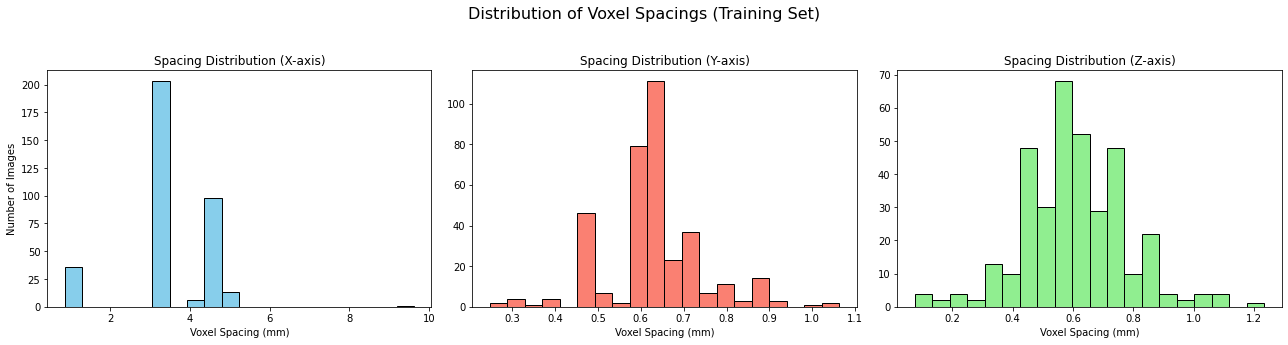


Analyzing files in: C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER\imagesTs
Processed 90 images.


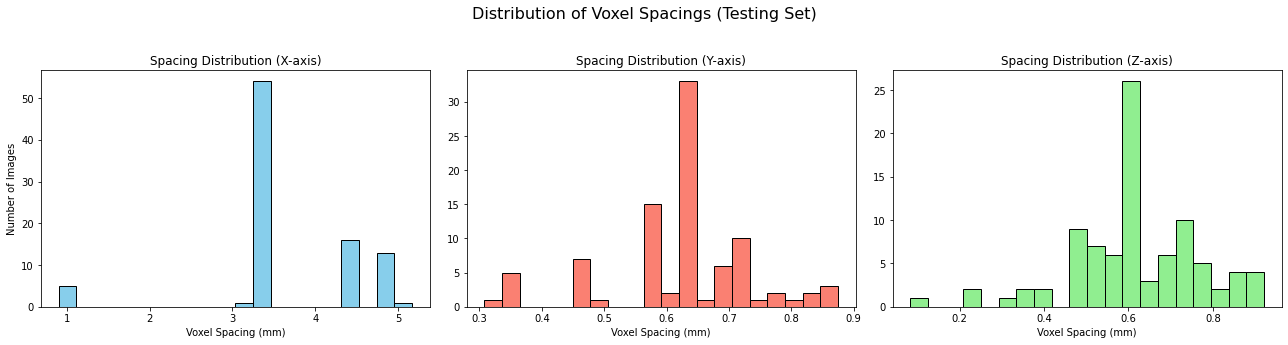

In [16]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

def analyze_and_plot_for_folder(folder_path, plot_title):
    """
    Analyzes all NIfTI files in a folder and generates a histogram plot
    of their voxel spacings.
    """
    spacings_x, spacings_y, spacings_z = [], [], []

    print(f"\nAnalyzing files in: {folder_path}")

    # Loop through all files and collect spacing data
    for filename in os.listdir(folder_path):
        if filename.endswith((".nii", ".nii.gz")):
            image_path = os.path.join(folder_path, filename)
            try:
                img = nib.load(image_path)
                zooms = img.header.get_zooms()
                spacings_x.append(zooms[0])
                spacings_y.append(zooms[1])
                spacings_z.append(zooms[2])
            except Exception as e:
                print(f"Could not process {filename}: {e}")

    if not spacings_x:
        print("No valid NIfTI files found in this folder.")
        return

    print(f"Processed {len(spacings_x)} images.")
    
    # --- Plotting the Histograms ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(plot_title, fontsize=16)

    # Histogram for X-axis
    axs[0].hist(spacings_x, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title('Spacing Distribution (X-axis)')
    axs[0].set_xlabel('Voxel Spacing (mm)')
    axs[0].set_ylabel('Number of Images')

    # Histogram for Y-axis
    axs[1].hist(spacings_y, bins=20, color='salmon', edgecolor='black')
    axs[1].set_title('Spacing Distribution (Y-axis)')
    axs[1].set_xlabel('Voxel Spacing (mm)')

    # Histogram for Z-axis
    axs[2].hist(spacings_z, bins=20, color='lightgreen', edgecolor='black')
    axs[2].set_title('Spacing Distribution (Z-axis)')
    axs[2].set_xlabel('Voxel Spacing (mm)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- PLEASE UPDATE THESE PATHS ---

# 1. Path to the base folder where you created the split dataset
output_split_folder = 'C:/ADLM/Datasets/SPIDER_FULL_FINAL/10159290/Dataset077_SPIDER'

# --- Run the analysis for both Train and Test sets ---

# Define paths for the training and testing image folders
train_images_folder = os.path.join(output_split_folder, 'imagesTr')
test_images_folder = os.path.join(output_split_folder, 'imagesTs')

# Generate the plot for the TRAINING set
if os.path.exists(train_images_folder):
    analyze_and_plot_for_folder(
        train_images_folder, 
        'Distribution of Voxel Spacings (Training Set)'
    )
else:
    print(f"Training folder not found at: {train_images_folder}")

# Generate the plot for the TESTING set
if os.path.exists(test_images_folder):
    analyze_and_plot_for_folder(
        test_images_folder, 
        'Distribution of Voxel Spacings (Testing Set)'
    )
else:
    print(f"Testing folder not found at: {test_images_folder}")